In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.ticker import ScalarFormatter

from gchp_log_parser import timing_from_log, timing_from_multi_logs

# Read logs

In [2]:
ls logs/

AWS/           Pleiades/      ipm_profiling/


In [3]:
df_nas = timing_from_multi_logs([6, 12, 24, 48], 24, './logs/Pleiades/N{0}n{1}_4x5met.log')
df_nas

,GIGCchem,Total,DYNAMICS,HIST,EXTDATA,N,n
0,24182.780,46225.8530,7452.582,159.991,1568.968,6,144
1,12195.172,26191.3452,3994.362,352.164,1818.643,12,288
2,6237.633,14419.2786,2285.235,162.684,1414.573,24,576
3,3395.856,8821.9649,1450.655,164.002,1583.643,48,1152


In [4]:
df_ompi = timing_from_multi_logs([4, 8, 16, 32], 36, './logs/AWS/N{0}n{1}_openmpi_4x5met.log')
df_ompi

,GIGCchem,Total,DYNAMICS,HIST,EXTDATA,N,n
0,17384.011,34383.6400,6009.648,548.044,901.626,4,144
1,8962.487,19859.5140,3180.133,753.909,1204.435,8,288
2,4697.651,13199.0756,2064.442,641.115,2382.313,16,576
3,2847.689,17916.1160,2361.187,727.341,8932.686,32,1152


In [5]:
df_impi = timing_from_multi_logs([4, 8, 16, 32], 36, './logs/AWS/N{0}n{1}_intelmpi-EFA_4x5met.log')
df_impi

,GIGCchem,Total,DYNAMICS,HIST,EXTDATA,N,n
0,13663.165,33018.7082,5790.683,566.402,1279.756,4,144
1,7176.431,18911.0890,3091.495,607.441,1270.854,8,288
2,3666.956,11976.7416,1779.877,602.992,1231.577,16,576
3,2010.783,7186.9350,1143.111,606.892,1437.415,32,1152


## Compare with IPM turned on

In [6]:
timing_from_multi_logs([4, 8, 16, 32], 36, './logs/AWS/with_IPM/N{0}n{1}_openmpi_4x5met_withIPM_nooutput.log')

,GIGCchem,Total,DYNAMICS,HIST,EXTDATA,N,n
0,17496.241,33981.5108,5872.279,0.010,904.837,4,144
1,8864.536,19351.0290,3122.941,0.009,1154.559,8,288
2,4636.975,13876.4618,1995.180,0.009,2341.714,16,576
3,2698.586,18040.2470,1667.764,0.009,5054.844,32,1152


In [7]:
timing_from_multi_logs([4, 8, 16, 32], 36, './logs/AWS/with_IPM/N{0}n{1}_intelmpi-EFA_4x5met_withIPM_nooutput.log')

,GIGCchem,Total,DYNAMICS,HIST,EXTDATA,N,n
0,13504.387,32209.1493,5763.810,0.010,1276.831,4,144
1,7023.426,18218.9995,3092.893,0.009,1167.600,8,288
2,3642.515,10498.3955,1781.429,0.008,1218.607,16,576
3,1958.983,6858.0785,1140.605,0.009,1385.327,32,1152


# Plot

In [8]:
def plot_ideal(ax, y_starts):
    x_grid = np.arange(144, 1152+1, 36)
    
    for y_start in y_starts:
        y_grid = y_start * (x_grid[0] / x_grid)
        
        ax.plot(x_grid, y_grid, '--', c='grey', alpha=0.4)

In [9]:
plt.rcParams['font.size'] = 16

def plot_scaling(ax, var='Total', title='Time for entire model', logy=True,
                 yticks=None, ylim=None, add_ideal=True, y_starts=()):

    n_list = df_impi['n'].values
    t_impi = df_impi[var].values/3600
    t_ompi = df_ompi[var].values/3600
    t_nas = df_nas[var].values/3600
    
    # time plot
    ax_kwargs = dict(linestyle='-', marker='o', linewidth=2.5, markersize=7.0, alpha=0.7)
    ax.plot(n_list, t_impi, **ax_kwargs, label='EC2 IntelMPI-EFA')
    ax.plot(n_list, t_ompi, **ax_kwargs, label='EC2 OpenMPI-TCP')    
    ax.plot(n_list, t_nas, **ax_kwargs, label='NASA Pleiades')
    
    if add_ideal:
        plot_ideal(ax, y_starts)

    ax.set_xscale('log')
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.minorticks_off()

    ax.set_xticks(n_list)
    
    if logy:
        ax.set_yscale('log')
        ax.yaxis.set_major_formatter(ScalarFormatter())
        ax.minorticks_off()

    if yticks is not None:
        ax.set_yticks(yticks)
    ax.set_ylim(ylim)

    ax.set_xlabel('Number of cores')
    ax.set_ylabel('Time (hours)')
    ax.set_title(title)

In [10]:
def true_logspace(start, stop, num):
    true_start = np.log10(start)
    true_stop = np.log10(stop)
    return np.logspace(true_start, true_stop, num, base=10.0)

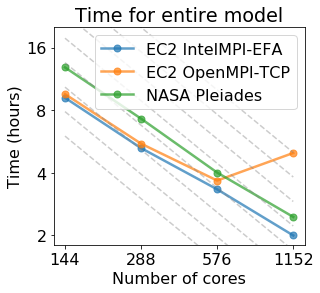

In [11]:
fig, ax = plt.subplots(1, 1, figsize=[4.5, 4])

plot_scaling(
    ax, 
    yticks=[2, 4, 8, 16], ylim=[1.8, 20],
    y_starts = true_logspace(6, 40, 8)
)
ax.legend()

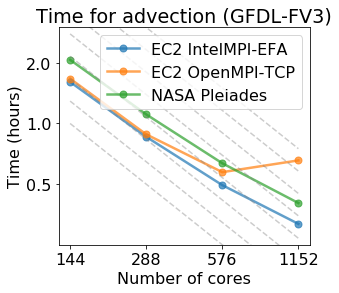

In [12]:
fig, ax = plt.subplots(1, 1, figsize=[4.5, 4])

plot_scaling(
    ax, var='DYNAMICS', title='Time for advection (GFDL-FV3)',
    yticks=[0.5, 1, 2.0], ylim=[0.25, 3.0],
    y_starts = true_logspace(1.0, 6.0, 8)
)
ax.legend()

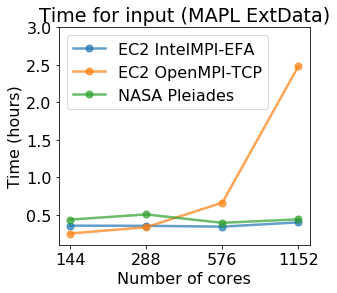

In [13]:
fig, ax = plt.subplots(1, 1, figsize=[4.5, 4])

plot_scaling(ax, var='EXTDATA', title='Time for input (MAPL ExtData)', 
             ylim=[0.1, 3], add_ideal=False, logy=False
            )
ax.legend()

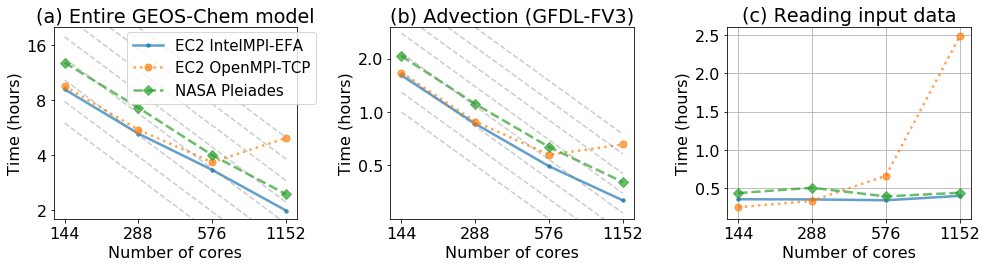

In [14]:
fig, axes = plt.subplots(1, 3, figsize=[14, 4])

plot_scaling(
    axes[0], var='Total',  title='(a) Entire GEOS-Chem model',
    yticks=[2, 4, 8, 16], ylim=[1.8, 20],
    y_starts = true_logspace(6, 40, 8)
)

plot_scaling(
    axes[1], var='DYNAMICS', title='(b) Advection (GFDL-FV3)',
    yticks=[0.5, 1, 2.0], ylim=[0.25, 3.0],
    y_starts = true_logspace(1.0, 6.0, 8)
)

plot_scaling(axes[2], var='EXTDATA', title='(c) Reading input data', 
             ylim=[0.1, 2.6], add_ideal=False, logy=False,
            )
axes[2].grid()

marker_list = ['.','o','D']
linestyle_list = ['-',':','--']
for ax in axes:
    for i, line in enumerate(ax.get_lines()[:3]):
        line.set_marker(marker_list[i])
        line.set_linestyle(linestyle_list[i])

fig.tight_layout()
axes[0].legend(loc=[0.3, 0.6], fontsize=15)

fig.savefig('gchp_scaling.png', dpi=300)